# A guide through compilation in Python using Electrostatics

On the computation of the follow values

$$\sum_{i >j } \frac{q_i q_j}{r_{ij}}$$

In [1]:
import numpy as np
import cython
import numexpr
%load_ext cython
%matplotlib inline

In [2]:
def build_system(n, extent=(10, 10, 10), q=(-10, 10)):
    """Constucts a trial system in cartesian coordinates with random charges.
    """
    xyz = np.random.rand(n, 3) * np.array(extent)
    q = np.random.randint(*q, size=n)
    return (xyz, q)

In [3]:
xyz, q = build_system(1000)
# print(xyz)
# print(q)

In [4]:
def naive_electrostatics(xyz, q):
    """Electostatics with simply python for loops
    """
    ret = 0.0
    size = xyz.shape[0]
    for x in range(size):
        for y in range(x + 1, size):
            dx = xyz[x, 0] - xyz[y, 0]
            dy = xyz[x, 1] - xyz[y, 1]
            dz = xyz[x, 2] - xyz[y, 2]
            
            r = (dx * dx + dy * dy + dz * dz) ** 0.5
            ret += q[x] * q[y] / r
    return ret

print(naive_electrostatics(xyz, q))
ttime = %timeit -o naive_electrostatics(xyz, q)
print(ttime.worst)

15283.767279384392
2.71 s ± 14.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.7440207569889026


In [5]:
def numpy_electrostatics(xyz, q):
    """Electostatics with simply python for loops
    """
    ret = 0.0
    size = xyz.shape[0]
    for x in range(size):
        dxyz = xyz[:x] - xyz[x]
        r = np.sqrt(np.einsum('ij,ij->i', dxyz, dxyz))
        ret += np.sum(q[:x] * q[x] / r)
    return ret

print(numpy_electrostatics(xyz, q))
%timeit numpy_electrostatics(xyz, q)

15283.76727938435
34 ms ± 343 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Cython implementation

In [6]:
%%cython --annotate

def cython1_electrostatics(xyz, q):
    """Electostatics with simply python for loops
    """
    ret = 0.0
    size = xyz.shape[0]
    for x in range(size):
        for y in range(x + 1, size):
            dx = xyz[x, 0] - xyz[y, 0]
            dy = xyz[x, 1] - xyz[y, 1]
            dz = xyz[x, 2] - xyz[y, 2]
            
            r = (dx * dx + dy * dy + dz * dz) ** 0.5
            ret += q[x] * q[y] / r
    return ret


In [7]:
print(cython1_electrostatics(xyz, q))
%timeit cython1_electrostatics(xyz, q)

15283.767279384392
2.39 s ± 21.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%cython --annotate

cimport cython
cimport numpy as np

def cython2_electrostatics(np.ndarray[np.double_t, ndim=2] xyz, np.ndarray[np.int_t, ndim=1] q):
    """Electostatics with simply python for loops
    """
    cdef np.double_t ret = 0.0
    cdef int size = xyz.shape[0]
    
    cdef np.double_t dx, dy, dz, r
    cdef int x, y
    
    for x in range(size):
        for y in range(x + 1, size):
            dx = xyz[x, 0] - xyz[y, 0]
            dy = xyz[x, 1] - xyz[y, 1]
            dz = xyz[x, 2] - xyz[y, 2]
            
            r = (dx * dx + dy * dy + dz * dz) ** 0.5
            ret += q[x] * q[y] / r
    return ret

In [9]:
print(cython2_electrostatics(xyz, q))
%timeit cython2_electrostatics(xyz, q)

15283.767279384392
38.6 ms ± 223 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
%%cython

cimport cython
cimport cython.parallel
cimport numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True) 
def cython3_electrostatics(np.ndarray[np.double_t, ndim=2] xyz, np.ndarray[np.int_t, ndim=1] q):
    """Electostatics with simply python for loops
    """
    cdef np.double_t ret = 0.0
    cdef int size = xyz.shape[0]
    
    cdef np.double_t dx, dy, dz, r
    cdef int x, y
    
    for x in cython.parallel.prange(size, nogil=True, schedule="guided"):
        for y in range(x + 1, size):
            dx = xyz[x, 0] - xyz[y, 0]
            dy = xyz[x, 1] - xyz[y, 1]
            dz = xyz[x, 2] - xyz[y, 2]
            
            r = (dx * dx + dy * dy + dz * dz) ** 0.5
            ret += q[x] * q[y] / r
    return ret

In [11]:
print(cython3_electrostatics(xyz, q))
%timeit cython3_electrostatics(xyz, q)

15283.767279384392
37.6 ms ± 250 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Numba

In [12]:
import numba
jit_electrostatics = numba.jit(naive_electrostatics, nopython=True)

print(jit_electrostatics(xyz, q))
%timeit jit_electrostatics(xyz, q)

15283.767279384392
2.6 ms ± 22.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
def prange_electrostatics(xyz, q):
    """Electostatics with simply python for loops
    """
    ret = 0.0
    size = xyz.shape[0]
    for x in numba.prange(size):
        for y in range(x + 1, size):
            dx = xyz[x, 0] - xyz[y, 0]
            dy = xyz[x, 1] - xyz[y, 1]
            dz = xyz[x, 2] - xyz[y, 2]
            
            r = (dx * dx + dy * dy + dz * dz) ** 0.5
            ret += q[x] * q[y] / r
    return ret

jit_prange_electrostatics = numba.jit(prange_electrostatics, nopython=True, parallel=True)

print(jit_prange_electrostatics(xyz, q))
%timeit jit_prange_electrostatics(xyz, q)

15283.7672793845
1.56 ms ± 5.86 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
# Required CUDA GPU's 'conda install cudatoolkit
#gpujit_prange_electrostatics = numba.cuda.jit(prange_electrostatics, nopython=True)

# print(gpujit_prange_electrostatics(xyz, q))
# %timeit gpujit_prange_electrostatics(xyz, q)

In [14]:
import seaborn
import pandas as pd

func_dict = {
    "python": naive_electrostatics,
    "numpy": numpy_electrostatics,
    "cython2": cython2_electrostatics,
    "cython3": cython3_electrostatics,
    "jit": jit_electrostatics,
    "jit_prange": jit_prange_electrostatics,
}

active = {k : True for k in func_dict.keys()}

sizes = [1e1, 1e2, 1e3, 1e4]
df = []

for s in sizes:
    tmp_xyz, tmp_q = build_system(int(s))
    print("\nTimes for size {}".format(s))
    print("----------------------------")
    for name, func in func_dict.items():
        

        # Filter out very long runs
        if not active[name]:
            continue
            
        print("\nTiming function {}:".format(name))

        
        timing = %timeit -o func(tmp_xyz, tmp_q)
        df.append([s, name, timing.best])
        
        if timing.best > 0.5:
            active[name] = False

df = pd.DataFrame(df, columns=["Size", "Algorithm", "Time [s]"])


Times for size 10.0
----------------------------

Timing function python:
263 µs ± 1.96 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Timing function numpy:
260 µs ± 20.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Timing function cython2:
4.08 µs ± 48.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

Timing function cython3:
4.13 µs ± 5.11 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

Timing function jit:
717 ns ± 4.58 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)

Timing function jit_prange:
4.18 µs ± 11.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

Times for size 100.0
----------------------------

Timing function python:
28.3 ms ± 331 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Timing function numpy:
2.61 ms ± 210 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Timing function cython2:
379 µs ± 609 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Timing function

In [16]:
df

,Size,Algorithm,Time [s]
0,10.0,python,2.604008e-04
1,10.0,numpy,2.193560e-04
2,10.0,cython2,4.053538e-06
3,10.0,cython3,4.122276e-06
4,10.0,jit,7.135388e-07
5,10.0,jit_prange,4.164621e-06
6,100.0,python,2.792116e-02
7,100.0,numpy,2.225166e-03
8,100.0,cython2,3.784911e-04
9,100.0,cython3,3.657826e-04


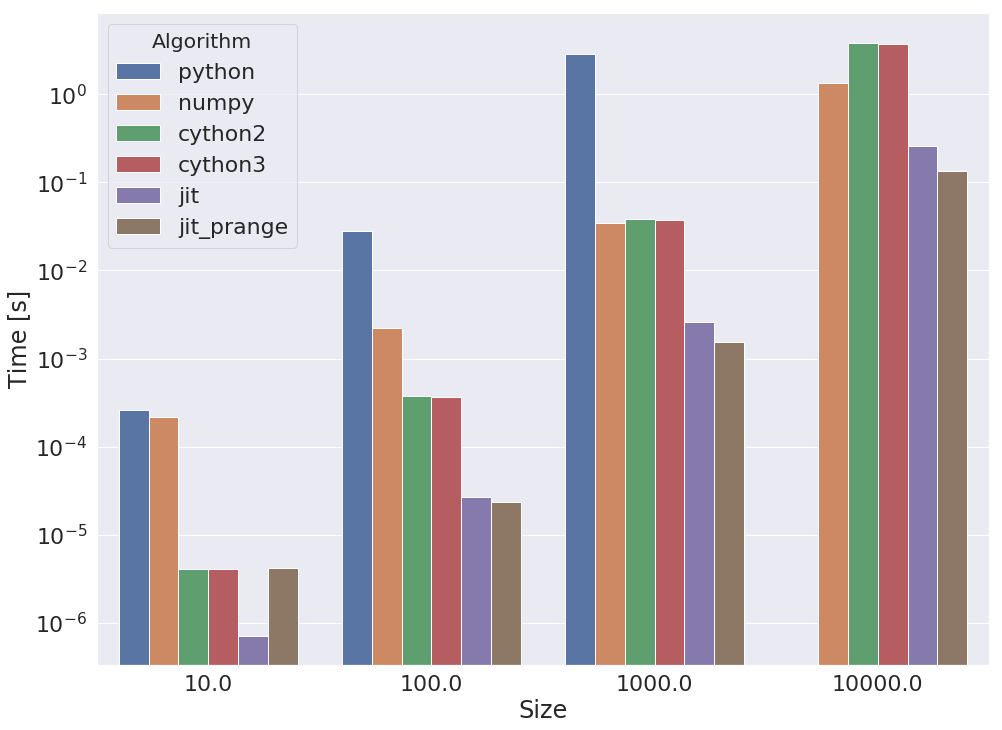

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=2)
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)

g = sns.barplot(x="Size", y="Time [s]", hue="Algorithm", data=df, ax=ax)
g.set_yscale('log')

# Numexpr

In [18]:
size = int(1e6)

a = np.random.rand(size)
b = np.random.rand(size)
c = np.random.rand(size)

In [19]:
def numpy_expression(a, b, c):
    return np.sin(a) + np.exp(b) + np.tan(c)

In [20]:
%timeit numpy_expression(a, b, c)

10.5 ms ± 318 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
jit_expression = numba.jit(numpy_expression, nopython=True)
%timeit jit_expression(a, b, c)

30.7 ms ± 681 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
t = %timeit -o numexpr.evaluate("sin(a) + exp(b) + tan(c)", {"a": a, "b": b, "c": c})

2.67 ms ± 53.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
t.all_runs

[0.2582112350210082,
 0.26265792999765836,
 0.2764976409962401,
 0.27086991898249835,
 0.26743440702557564,
 0.2673509760061279,
 0.26597568299621344]